9000 Circles

Author - Connor Haworth

The work in this notebook is based on the artwork created by Hamid Naderi Yeganeh.

The original work can be found at https://blogs.scientificamerican.com/guest-blog/making-mathematical-art/.

This notebook features the design from the above source entitled 9000 circles.

This design is a hardware accelerated model designed to be run on the PYNQ-Z2 board.

Start by importing the required libraries for mathematical functions and graph plotting.

In [1]:
import matplotlib.pyplot as plt
import math

Convert the values received from the PYNQ-Z2 board from 32 bit unsigned numbers to signed binary numbers, with a singular sign bit and 31 fractional bits.

In [2]:
def to_signedfract(val,b):
    val_str = (bin(val)[2:]).zfill(b);
    return -1*int(val_str[0]) + int(val_str[1:], 2) / 2.** (b-1)

The design from the aforementioned artwork by Hamid Naderi Yeganeh plots 9000 circles. Each circle can be represented by the following formulas, where:
 k = 1,2,...,9000
 Centre of circle = (X(k),Y(k))
 Radius of circle = R(k)

System generator was used to create a block diagram which calculates the X and Y coordinates along with the radius of each circle. Each value for the sine and cosine functions are stored in lookup tables and are addressed by the variable K. These values were then passed through the various mathematical function blocks required in order to match the aforementioned equations, with delay blocks added to ensure that the path lengths for branches which interact with eachother are equal.

Once the block diagram had been created, the IP Core had to be generated as well as the interface document in order to create an overlay for the PYNQ-Z2 board.

Once the IP core and interface document generation was completed, Vivado was then used in order to design the overlay for the PYNQ-Z2 board.The following diagram is what was created using block and connection automation in Vivado.

This was then used to generate the hardware handoff file and the bit file for the design, which are include in this project folder. The following code then declares a custom driver for the IP.
This allows the processing system to read and write to the programmable logic efficiently.
This overlay was then used to generate the bit file and hardware handoff file necessary to allow the logic on the board to be programmed.
The following code then creates a custom driver for the IP, this code was developed with the help of the PYNQ Practical 3.

In [3]:
from pynq import DefaultIP
class AddDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
    bindto = ['User_Company:SysGen:circles_9k:1.0']
    def getX(self, k):
        self.write(0x00, k) 
        return to_signedfract(self.read(0xC),32)
    
    def getY(self, k):
        self.write(0x00, k) 
        return to_signedfract(self.read(0x04),32) 
    
    def getR(self, k):
        self.write(0x00, k) 
        return to_signedfract(self.read(0x08),32)
    
    def getValues(self, k):
        self.write(0x00, k)
        return to_signedfract(self.read(0xC),32),to_signedfract(self.read(0x04),32),to_signedfract(self.read(0x08),32)

Next the custom overlay was imported using the Overlay function from the pynq library.

In [4]:
from pynq import Overlay
ol = Overlay("design_1_wrapper.bit");

The next line of code is added to give a more convenient name to the IP.

In [5]:
circles_9k = ol.circles_9k_0

The following function retrieves the values of the coordinates and radius calculated by the programmable logic. The colour of the circles is gradually changed throughout the loop iteration, in this example PuRd and plasma are used, however this can be changed easily and the following options are listed below.

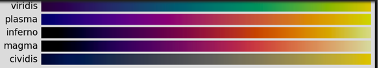

In [6]:
def plot_values():
    figure, axes = plt.subplots(dpi = 600)
    X, Y, R = 0, 0, 0
    for i in range(1,9000):
        
        if i <= 4500:
            #COLOUR CODE CHANGE
            colour_grad = plt.cm.PuRd (i/4500)
        else:
            #COLOUR CODE CHANGE
            colour_grad = plt.cm.plasma((i-4500)/4500)
            
        X,Y,R = circles_9k.getValues(i);
        axes.add_artist(plt.Circle((X, Y), R, fill=False, linewidth=0.1, color=colour_grad))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    axes.axis('off')
    axes.set_aspect(1)
    plt.show()  
    return

The next line of code calls the function and plots the circles on the graph. Runtime for this is fairly lengthy due to the large demand of plotting 9000 circles.

In [7]:
plot_values(); 

The final line of code is to demonstrate that despite the long runtime, the hardware is capable of carrying out the computation of the values rather quickly at a little over 2 seconds.

In [8]:
import time
start = time.time()
#Speed testing of programmable logic
for i in range(1,9000):
    xpos,ypos,rad =0,0,0
    xpos,ypos,rad = circles_9k.getValues(i);
end = time.time()   
total = end - start
print("Programmable logic computations took", total, "seconds.")

Programmable logic computations took 2.0741448402404785 seconds.
